In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import itertools


#ARIMAX Models packages
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#GARCH Model Package
from arch import arch_model

#Neural Network packages
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l2

In [2]:
#df_cons = pd.read_excel('datasets/Actual_consumption_202001010000_202011242359.xlsx', skiprows=6,na_values='-')
#df_price = pd.read_excel('datasets/Day-ahead_prices_202001010000_202011242359.xlsx', skiprows=6, na_values='-')
#df_gen = pd.read_excel('datasets/Actual_generation_202001010000_202011242359.xlsx', skiprows=6, na_values='-')

df_cons = pd.read_excel('datasets/Actual_consumption_201901010000_202011302359.xlsx', skiprows=6,na_values='-')
df_price = pd.read_excel('datasets/Day-ahead_prices_201901010000_202011302359.xlsx', skiprows=6, na_values='-')
df_gen = pd.read_excel('datasets/Actual_generation_201901010000_202011302359.xlsx', skiprows=6, na_values='-')

df_test = pd.read_excel('datasets/Day-ahead_prices_202012010000_202012312359.xlsx', skiprows=6, na_values='-')
df_test_cons = pd.read_excel('datasets/Actual_consumption_202012010000_202012312359.xlsx', skiprows=6, na_values='-')
df_test_gen = pd.read_excel('datasets/Actual_generation_202012010000_202012312359.xlsx', skiprows=6, na_values='-')


df_price = df_price.append(pd.read_excel('datasets/Day-ahead_prices_201712010000_201812312359.xlsx', skiprows=6,na_values='-'))
df_cons = df_cons.append(pd.read_excel('datasets/Actual_consumption_201712010000_201812312359.xlsx', skiprows=6,na_values='-'))
df_gen = df_gen.append(pd.read_excel('datasets/Actual_generation_201712010000_201812312359.xlsx', skiprows=6,na_values='-'))

#Concatenate Date + Time and create TimeSeries
df_cons['Date'] = pd.to_datetime(df_cons['Date'] + ' ' + df_cons['Time of day'])
#Create Timeseries index for 
#Drop Unused column
df_cons.drop('Time of day', axis=1, inplace=True)
#Create Timeseries index for
df_cons.set_index('Date', inplace=True)
#Convert to GWh for better Visualization
df_cons['Total[MWh]']/=1000
df_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)


#Concatenate Date + Time and create TimeSeries
df_test_cons['Date'] = pd.to_datetime(df_test_cons['Date'] + ' ' + df_test_cons['Time of day'])
#Create Timeseries index for 
#Drop Unused column
df_test_cons.drop('Time of day', axis=1, inplace=True)
#Create Timeseries index for
df_test_cons.set_index('Date', inplace=True)
#Convert to GWh for better Visualization
df_test_cons['Total[MWh]']/=1000
df_test_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)


#Repeat the same steps for Prices Dataset
df_price['Date'] = pd.to_datetime(df_price['Date'] + ' ' + df_price['Time of day'])
df_price.set_index('Date', inplace=True)
df_price.drop(df_price.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
#Remove Market Signals
df_price = df_price[~df_price.index.duplicated(keep='first')]
df_price['Germany/Luxembourg[€/MWh]'] = df_price[df_price['Germany/Luxembourg[€/MWh]'] > 1]


#Repeat the same steps for Test Dataset
df_test['Date'] = pd.to_datetime(df_test['Date'] + ' ' + df_test['Time of day'])
df_test.set_index('Date', inplace=True)
df_test.drop(df_test.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
#Remove Market Signals
df_test['Germany/Luxembourg[€/MWh]'] = df_test[df_test['Germany/Luxembourg[€/MWh]'] > 1]

#Repeat the same steps for Power Generation Dataset 
df_gen['Date'] = pd.to_datetime(df_gen['Date'] + ' ' + df_gen['Time of day'])
df_gen.drop('Time of day', axis=1, inplace=True)
df_gen.set_index('Date', inplace=True)

#Repeat the same steps for Power Generation Dataset 
df_test_gen['Date'] = pd.to_datetime(df_test_gen['Date'] + ' ' + df_test_gen['Time of day'])
df_test_gen.drop('Time of day', axis=1, inplace=True)
df_test_gen.set_index('Date', inplace=True)


#Create the Total Power Generation Column also known as Sypply
df_gen['TotalGeneration[MWh]'] = (df_gen['Biomass[MWh]'] + 
        df_gen['Hydropower[MWh]']+
        df_gen['Wind offshore[MWh]'] +
        df_gen['Wind onshore[MWh]']+
        df_gen['Photovoltaics[MWh]']+
        df_gen['Other renewable[MWh]']+ 
        df_gen['Nuclear[MWh]']+ 
        df_gen['Fossil brown coal[MWh]']+
        df_gen['Fossil hard coal[MWh]']+ 
        df_gen['Fossil gas[MWh]']+ 
        df_gen['Hydro pumped storage[MWh]']+
        df_gen['Other conventional[MWh]'])

#Convert all columns to GWh
df_gen['TotalGeneration[MWh]']/=1000  
df_gen['Biomass[MWh]']/=1000
df_gen['Hydropower[MWh]']/=1000
df_gen['Wind offshore[MWh]']/=1000
df_gen['Wind onshore[MWh]']/=1000
df_gen['Photovoltaics[MWh]']/=1000
df_gen['Other renewable[MWh]']/=1000
df_gen['Nuclear[MWh]']/=1000
df_gen['Fossil brown coal[MWh]']/=1000
df_gen['Fossil hard coal[MWh]']/=1000
df_gen['Fossil gas[MWh]']/=1000
df_gen['Hydro pumped storage[MWh]']/=1000
df_gen['Other conventional[MWh]']/=1000

df_gen.rename(columns={'TotalGeneration[MWh]': 'TotalGeneration[GWh]',
                       'Biomass[MWh]':'Biomass[GWh]',
                       'Hydropower[MWh]': 'Hydropower[GWh]',
                       'Wind offshore[MWh]': 'Wind offshore[GWh]',
                       'Wind onshore[MWh]':'Wind onshore[GWh]',
                       'Photovoltaics[MWh]':'Photovoltaics[GWh]',
                       'Other renewable[MWh]':'Other renewable[GWh]',
                       'Nuclear[MWh]':'Nuclear[GWh]',
                       'Fossil brown coal[MWh]':'Fossil brown coal[GWh]',
                       'Fossil hard coal[MWh]':'Fossil hard coal[GWh]',
                       'Fossil gas[MWh]':'Fossil gas[GWh]',
                       'Hydro pumped storage[MWh]':'Hydro pumped storage[GWh]',
                       'Other conventional[MWh]':'Other conventional[GWh]'                      
                      }, inplace=True)

#Create the Total Power Generation Column also known as Sypply
df_test_gen['TotalGeneration[MWh]'] = (df_test_gen['Biomass[MWh]'] + 
        df_test_gen['Hydropower[MWh]']+
        df_test_gen['Wind offshore[MWh]'] +
        df_test_gen['Wind onshore[MWh]']+
        df_test_gen['Photovoltaics[MWh]']+
        df_test_gen['Other renewable[MWh]']+ 
        df_test_gen['Nuclear[MWh]']+ 
        df_test_gen['Fossil brown coal[MWh]']+
        df_test_gen['Fossil hard coal[MWh]']+ 
        df_test_gen['Fossil gas[MWh]']+ 
        df_test_gen['Hydro pumped storage[MWh]']+
        df_test_gen['Other conventional[MWh]'])

#Convert all columns to GWh
df_test_gen['TotalGeneration[MWh]']/=1000  
df_test_gen['Biomass[MWh]']/=1000
df_test_gen['Hydropower[MWh]']/=1000
df_test_gen['Wind offshore[MWh]']/=1000
df_test_gen['Wind onshore[MWh]']/=1000
df_test_gen['Photovoltaics[MWh]']/=1000
df_test_gen['Other renewable[MWh]']/=1000
df_test_gen['Nuclear[MWh]']/=1000
df_test_gen['Fossil brown coal[MWh]']/=1000
df_test_gen['Fossil hard coal[MWh]']/=1000
df_test_gen['Fossil gas[MWh]']/=1000
df_test_gen['Hydro pumped storage[MWh]']/=1000
df_test_gen['Other conventional[MWh]']/=1000

df_test_gen.rename(columns={'TotalGeneration[MWh]': 'TotalGeneration[GWh]',
                       'Biomass[MWh]':'Biomass[GWh]',
                       'Hydropower[MWh]': 'Hydropower[GWh]',
                       'Wind offshore[MWh]': 'Wind offshore[GWh]',
                       'Wind onshore[MWh]':'Wind onshore[GWh]',
                       'Photovoltaics[MWh]':'Photovoltaics[GWh]',
                       'Other renewable[MWh]':'Other renewable[GWh]',
                       'Nuclear[MWh]':'Nuclear[GWh]',
                       'Fossil brown coal[MWh]':'Fossil brown coal[GWh]',
                       'Fossil hard coal[MWh]':'Fossil hard coal[GWh]',
                       'Fossil gas[MWh]':'Fossil gas[GWh]',
                       'Hydro pumped storage[MWh]':'Hydro pumped storage[GWh]',
                       'Other conventional[MWh]':'Other conventional[GWh]'                      
                      }, inplace=True)

#Downsample datasets to a daily frequency 
df_dcons = df_cons.resample('D').sum()
df_dgen = df_gen.resample('D').sum()
df_dprice = df_price.resample('D').median()

df_test = df_test.resample('D').median()
df_test_cons = df_test_cons.resample('D').sum()
df_test_gen = df_test_gen.resample('D').sum()

df_test = pd.merge(df_test, df_test_cons, left_index=True, right_index=True )
df_test = pd.merge(df_test, df_test_gen, left_index=True, right_index=True )

#Merge Datasets into a single one
df = pd.merge(df_dcons, df_dgen, left_index=True, right_index=True )
df = pd.merge(df, df_dprice, left_index=True, right_index=True )

#Calculate Non-base Demand According to the chosen paper
df['Non-base Demand[GWh]'] = df['TotalConsumption[GWh]'] - df['Hydropower[GWh]'] - df['Nuclear[GWh]']
df_test['Non-base Demand[GWh]'] = df_test['TotalConsumption[GWh]'] - df_test['Hydropower[GWh]'] - df_test['Nuclear[GWh]']


#Calculate Supply-Demand Index
df['SupplyDemandIndex[SDI]'] = (df['TotalGeneration[GWh]'] - df['TotalConsumption[GWh]'])/ df['TotalConsumption[GWh]']*100

#Get weekday
df['DoW'] = df.index.dayofweek

#Get holidays in Germany
de_holidays = holidays.DEU()
df['Weekend/Holiday'] = df.apply(lambda x: x.name in de_holidays or x.DoW in [5,6], axis=1)

#Window of 90 Days
window = 90

#remove rolls without prices
df = df[~df['Germany/Luxembourg[€/MWh]'].isnull()]
df['PriceDeviation'] = df['Germany/Luxembourg[€/MWh]'].rolling(window).std(win_type='gaussian')
#For displaying purpose
df['Non-base Demand[10GWh]'] = df['Non-base Demand[GWh]'] / 10

#Calculate Price Spike
df['PriceSpike'] =  df['Germany/Luxembourg[€/MWh]'] > df['Germany/Luxembourg[€/MWh]'].rolling(window).mean() + df['PriceDeviation'] * 2

<AxesSubplot:xlabel='Date'>

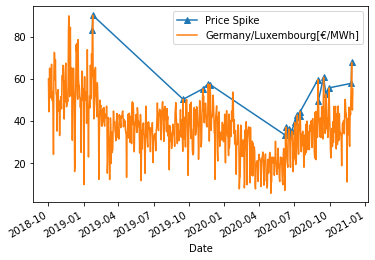

In [3]:
df[df['PriceSpike']]['Germany/Luxembourg[€/MWh]'].plot(marker='^',label='Price Spike', legend=True)
df['Germany/Luxembourg[€/MWh]'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

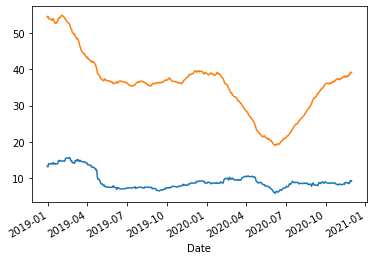

In [4]:
df['PriceDeviation'].plot()
df['Germany/Luxembourg[€/MWh]'].rolling(window).mean().plot()

<AxesSubplot:xlabel='Date'>

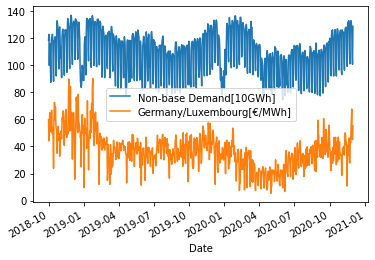

In [5]:
df[['Non-base Demand[10GWh]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)

<AxesSubplot:xlabel='Date'>

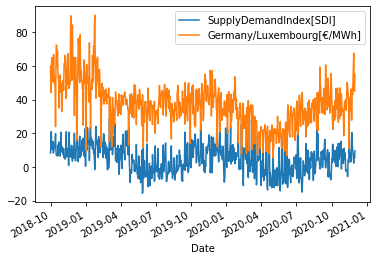

In [6]:
df[['SupplyDemandIndex[SDI]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)


In [7]:
#Skip Temperature and Capacity-Flow for simplicity

<AxesSubplot:xlabel='TotalConsumption[GWh]', ylabel='Germany/Luxembourg[€/MWh]'>

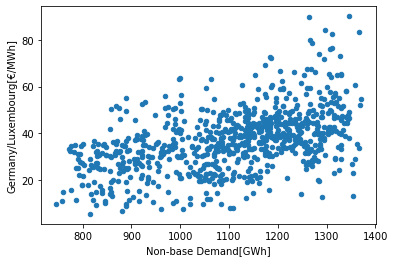

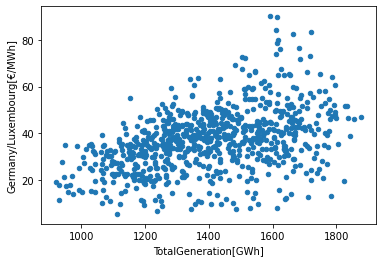

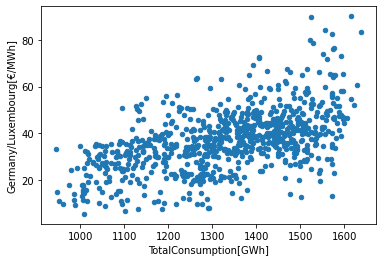

In [8]:
df.plot(kind='scatter', x='Non-base Demand[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalGeneration[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalConsumption[GWh]' ,y='Germany/Luxembourg[€/MWh]' )

In [9]:
df_normal = df[~df['PriceSpike']].copy()
df_normal.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

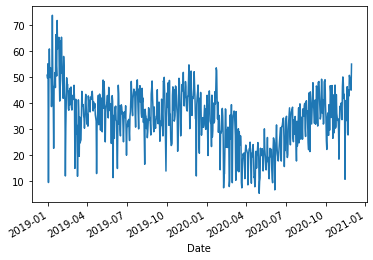

In [10]:
df_normal['Germany/Luxembourg[€/MWh]'].plot()

<Figure size 432x288 with 0 Axes>

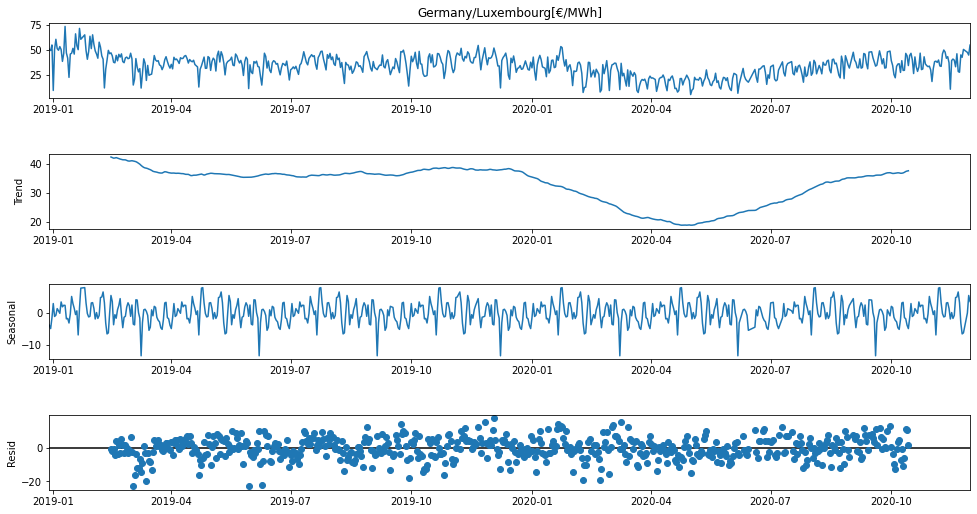

In [11]:
#Seasonal ARIMA model(SARIMA: Seasonal Auto Regressive Integrated Moving Average) with explanatory variables
decomposition = seasonal_decompose(df_normal['Germany/Luxembourg[€/MWh]'], period=window)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

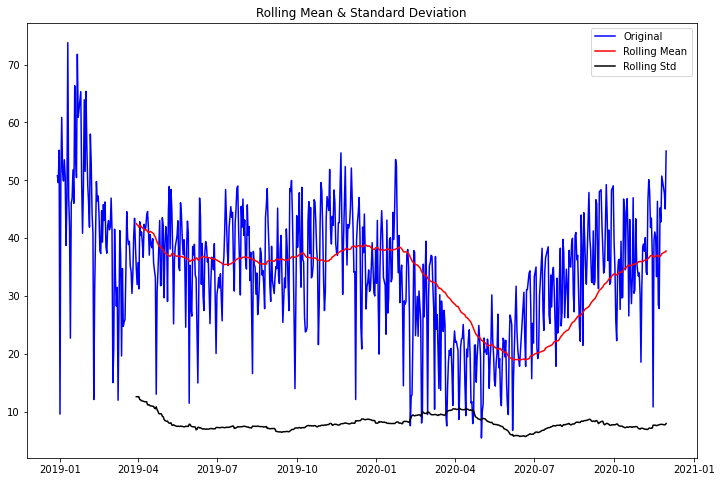

Results of Dickey-Fuller Test:
Test Statistic                  -2.282972
p-value                          0.177519
#Lags Used                      20.000000
Number of Observations Used    656.000000
Critical Value (1%)             -3.440358
Critical Value (5%)             -2.865956
Critical Value (10%)            -2.569122
dtype: float64


In [12]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


test_stationarity(df_normal['Germany/Luxembourg[€/MWh]'])

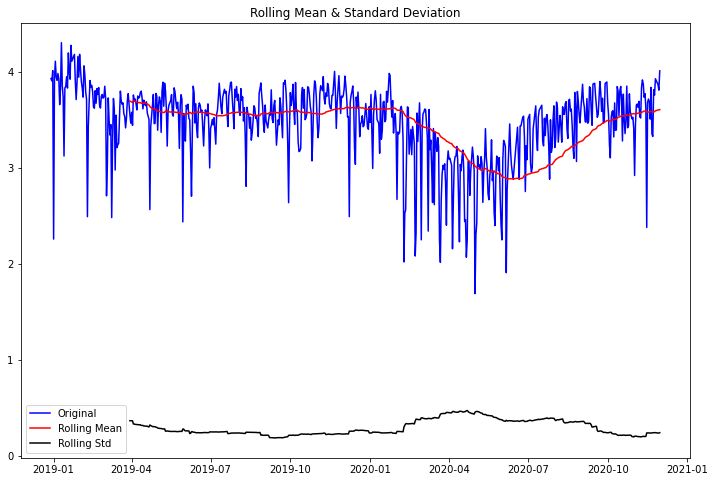

Results of Dickey-Fuller Test:
Test Statistic                  -2.116115
p-value                          0.238084
#Lags Used                      13.000000
Number of Observations Used    663.000000
Critical Value (1%)             -3.440252
Critical Value (5%)             -2.865909
Critical Value (10%)            -2.569097
dtype: float64


In [13]:
df_normal['log(Germany/Luxembourg[€/MWh])']= df_normal['Germany/Luxembourg[€/MWh]'].apply(lambda x: np.log(x))  
test_stationarity(df_normal['log(Germany/Luxembourg[€/MWh])'])
#Worse performance

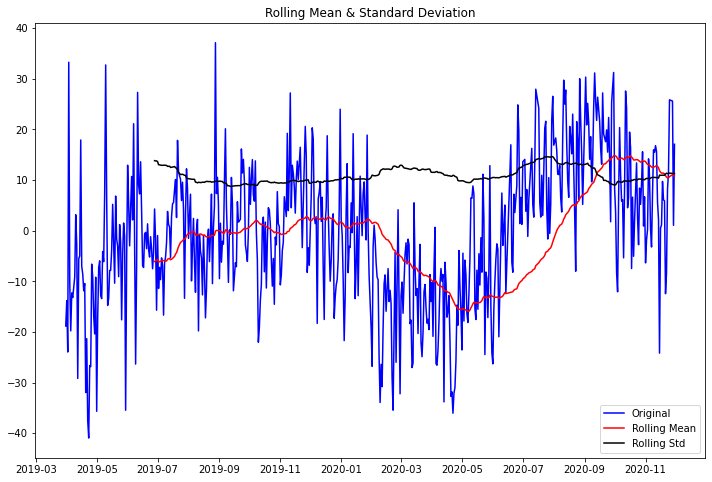

Results of Dickey-Fuller Test:
Test Statistic                  -2.551762
p-value                          0.103382
#Lags Used                      16.000000
Number of Observations Used    570.000000
Critical Value (1%)             -3.441875
Critical Value (5%)             -2.866624
Critical Value (10%)            -2.569478
dtype: float64


In [14]:
df_normal['seasonal_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(window)  
test_stationarity(df_normal['seasonal_difference'].dropna(inplace=False))
#Much better performance

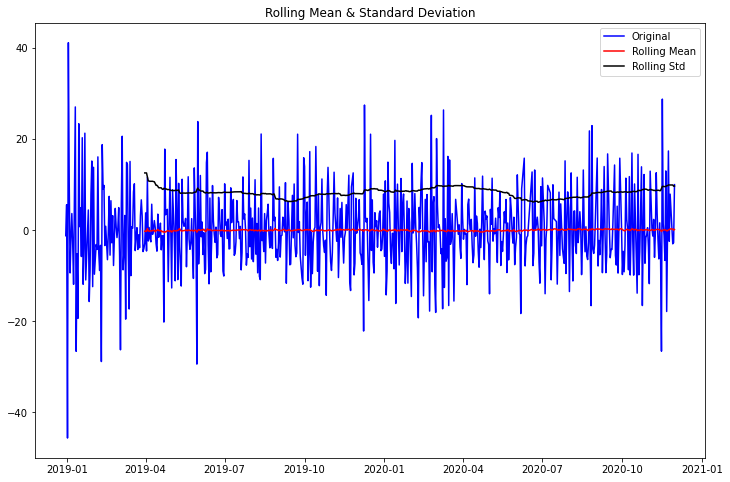

Results of Dickey-Fuller Test:
Test Statistic                -8.229371e+00
p-value                        6.121784e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.560000e+02
Critical Value (1%)           -3.440358e+00
Critical Value (5%)           -2.865956e+00
Critical Value (10%)          -2.569122e+00
dtype: float64


In [15]:
df_normal['first_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(1)  
test_stationarity(df_normal['first_difference'].dropna(inplace=False))
#Very significant p-value
#Data normalised 

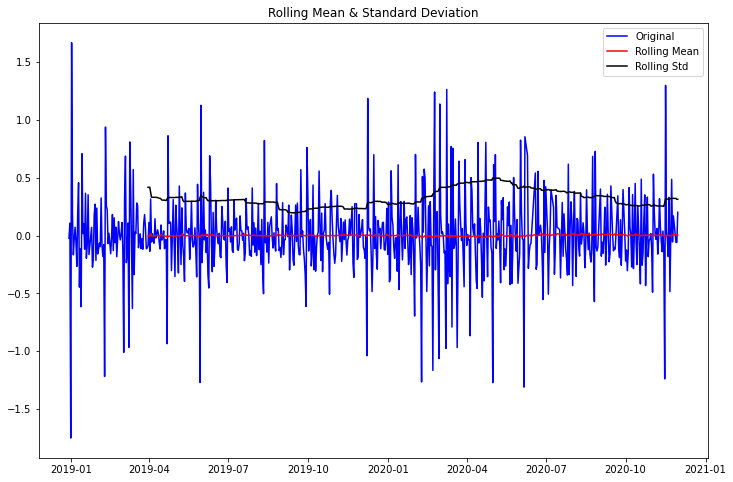

Results of Dickey-Fuller Test:
Test Statistic                -1.282848e+01
p-value                        5.943252e-24
#Lags Used                     1.200000e+01
Number of Observations Used    6.630000e+02
Critical Value (1%)           -3.440252e+00
Critical Value (5%)           -2.865909e+00
Critical Value (10%)          -2.569097e+00
dtype: float64


In [16]:
df_normal['first_difference_log']= df_normal['log(Germany/Luxembourg[€/MWh])'] - df_normal['log(Germany/Luxembourg[€/MWh])'].shift(1)
test_stationarity(df_normal['first_difference_log'].dropna(inplace=False))

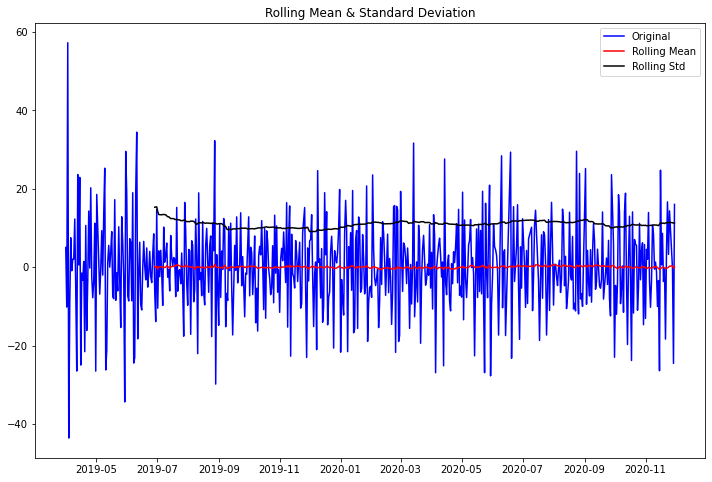

Results of Dickey-Fuller Test:
Test Statistic                -7.189964e+00
p-value                        2.518656e-10
#Lags Used                     1.500000e+01
Number of Observations Used    5.700000e+02
Critical Value (1%)           -3.441875e+00
Critical Value (5%)           -2.866624e+00
Critical Value (10%)          -2.569478e+00
dtype: float64


In [17]:
df_normal['seasonal_first_difference'] = df_normal['first_difference'] - df_normal['first_difference'].shift(window)  
test_stationarity(df_normal.seasonal_first_difference.dropna(inplace=False))
#Very Significant but not as much as the previous one

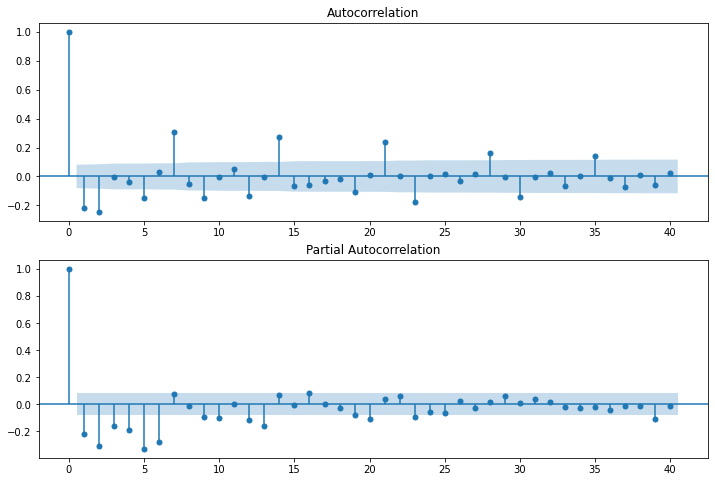

In [18]:
#Model Chosen 'first_difference'
#test_stationarity(df['first_difference'].dropna(inplace=False))

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax2)

In [19]:
def gridsearch_sarima():
    #set parameter range
    p = range(0,3)
    q = range(1,3)
    d = range(1,3)
    s = range(6,8)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    best_results = '' 
    best_aic = 100000000
    # SARIMA model pipeline
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'],
                                        order=param,
                                        trend='ct',
                                        seasonal_order=param_seasonal)
                results = mod.fit(max_iter = 50, method = 'powell')
                print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
                if results.aic < best_aic:
                    best_results = 'SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic)
                    best_aic = results.aic
                    best_param = param
                    best_param_seasonal = param_seasonal
            except:
                continue

    print('Best Results: SARIMA{},{} - AIC:{}'.format(best_param,best_param_seasonal, best_aic))
    return best_param, best_param_seasonal

In [20]:
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1

#order, seasonal_order = gridsearch_sarima() 
    
#BEST PARAMETERS GRID_SEARCH
order_sarima = (1, 1, 1)
seasonal_order = (2, 1, 1, 7)    

mod_sarima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], 
                                       order=order_sarima,
                                       seasonal_order=seasonal_order,
                                       trend='ct')
results_sarima = mod_sarima.fit(max_iter = 50, method = 'powell')
results_sarima.summary()

#In case we need the CI for the meodel
#res = mod_sarima.filter(results_sarima.params)
#predict = res.get_prediction()
#predict.predicted_mean['2020-11'].plot()


Optimization terminated successfully.
         Current function value: 3.148757
         Iterations: 10
         Function evaluations: 924


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:         Germany/Luxembourg[€/MWh]   No. Observations:                  703
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -2213.576
Date:                           Thu, 14 Jan 2021   AIC                           4443.152
Time:                                   19:39:59   BIC                           4479.504
Sample:                               12-29-2018   HQIC                          4457.209
                                    - 11-30-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.004     -0.111      0.912      -0.009       0.008
drift       5.112e-06   1.14e-05      0.448      0.654   -1.72e-05    2.75e-05
ar.L1          0.3287      0.043      7.669      0.000       0.245       0.413
ma.L1         -0.8935      0.027    -33.080      0.000      -0.946      -0.841
ar.S.L7        0.0776      0.040      1.952      0.051      -0.000       0.156
ar.S.L14       0.0581      0.039      1.491      0.136      -0.018       0.134
ma.S.L7       -0.9904      0.053    -18.712      0.000      -1.094      -0.887
sigma2        41.6874      2.457     16.965      0.000      36.871      46.503
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               203.31
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

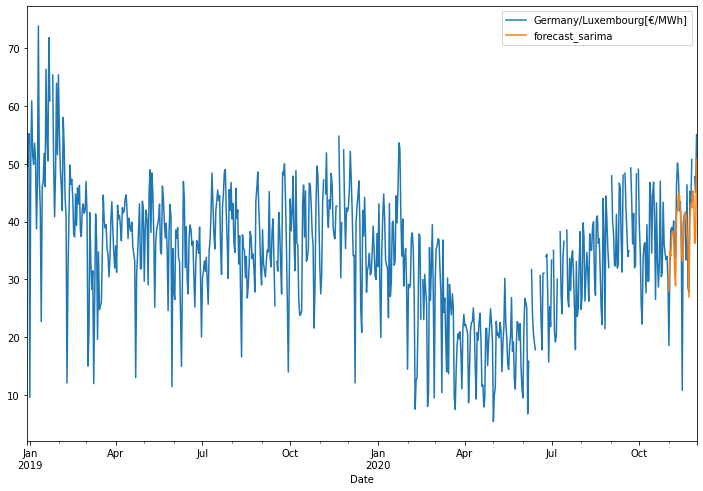

In [21]:
df_normal['forecast_sarima'] = results_sarima.predict(start = '2020-11-01', end= '2020-11-30') #,dynamic= True)  
df_normal['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_sarima']].plot(figsize=(12, 8))

In [22]:
def gridsearch_arima():
    import itertools
    #set parameter range
    p = range(0,6)
    q = range(0,6)
    d = range(0,6)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    best_results = '' 
    best_aic = 100000000
    # ARIMA model pipeline
    for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'],
                                            order=param, 
                                            enforce_invertibility=False)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
            if results.aic < best_aic:
                best_results = 'ARIMA{} - AIC:{}'.format(param,results.aic)
                best_aic = results.aic
                best_param = param
        except:
            continue

    print('Best Results: ARIMA{} - AIC:{}'.format(best_param, best_aic))
    return best_param

In [23]:
#Set index to period Day
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1

#order =  gridsearch_arima() #1 to get the first difference
order_arima = (4, 1, 5)
mod_arima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], trend='n', order=order_arima)
results_arima = mod_arima.fit()
results_arima.summary()

/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Germany/Luxembourg[€/MWh]   No. Observations:                  703
Model:                      SARIMAX(4, 1, 5)   Log Likelihood               -2258.979
Date:                       Thu, 14 Jan 2021   AIC                           4537.957
Time:                               19:40:03   BIC                           4583.497
Sample:                           12-29-2018   HQIC                          4555.559
                                - 11-30-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7733      0.015     50.176      0.000       0.743       0.803
ar.L2         -1.4262      0.012   -114.119      0.000      -1.451      -1.402
ar.L3          0.7865      0.013     61.147      0.000       0.761       0.812
ar.L4         -0.9627      0.014    -70.750      0.000      -0.989      -0.936
ma.L1         -1.4026      0.034    -41.061      0.000      -1.470      -1.336
ma.L2          1.7883      0.043     41.915      0.000       1.705       1.872
ma.L3         -1.6597      0.045    -36.628      0.000      -1.749      -1.571
ma.L4          1.3129      0.046     28.287      0.000       1.222       1.404
ma.L5         -0.6055      0.033    -18.323      0.000      -0.670      -0.541
sigma2        45.9394      1.732     26.517      0.000      42.544      49.335
===================================================================================
Ljung-Box (L1) (Q):                   2.71   Jarque-Bera (JB):               321.52
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

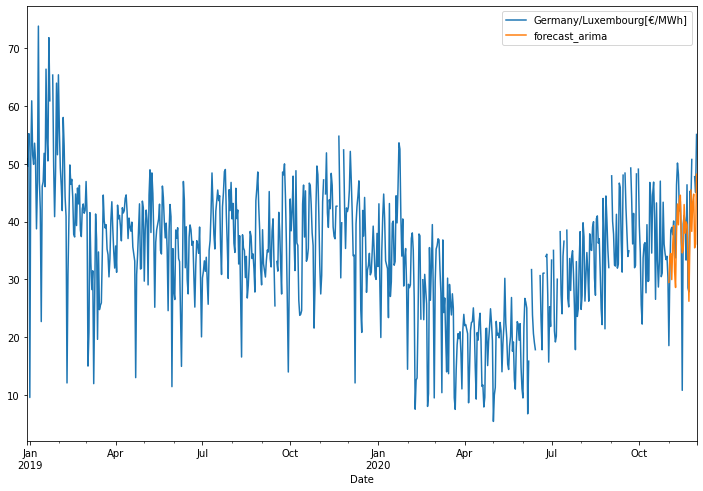

In [24]:
df_normal['forecast_arima'] = results_arima.predict(start = '2020-11-01', end= '2020-11-30')  # ,dynamic= True)  
df_normal['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_arima']].plot(figsize=(12, 8))

<AxesSubplot:xlabel='Date'>

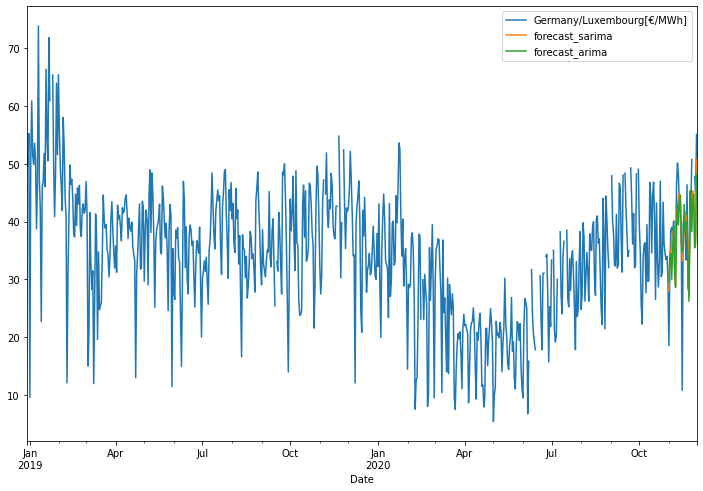

In [25]:
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_sarima', 'forecast_arima']].plot(figsize=(12, 8))

In [26]:
df_test['forecast_arima'] = results_arima.predict(start = '2020-12-01', end='2020-12-31')
df_test['forecast_sarima'] = results_sarima.predict(start = '2020-12-01', end='2020-12-31')
df_test

,Germany/Luxembourg[€/MWh],TotalConsumption[GWh],Residual load[MWh],Biomass[GWh],Hydropower[GWh],Wind offshore[GWh],Wind onshore[GWh],Photovoltaics[GWh],Other renewable[GWh],Nuclear[GWh],Fossil brown coal[GWh],Fossil hard coal[GWh],Fossil gas[GWh],Hydro pumped storage[GWh],Other conventional[GWh],TotalGeneration[GWh],Non-base Demand[GWh],forecast_arima,forecast_sarima
Date,,,,,,,,,,,,,,,,,,,
2020-12-01,57.650,1526.579,1328349,109.024,34.479,68.577,120.653,9.035,4.902,182.653,358.520,308.271,291.761,37.315,29.738,1554.928,1309.447,54.671946,50.421241
2020-12-02,80.345,1516.820,1400497,108.742,38.485,36.222,61.621,18.510,4.923,190.551,382.126,323.486,310.163,37.037,30.510,1542.376,1287.784,48.412454,50.034115
2020-12-03,48.730,1568.138,1083128,108.733,36.505,128.322,343.162,13.567,4.896,182.035,348.691,210.521,280.828,26.837,32.843,1716.940,1349.598,48.900145,49.340281
2020-12-04,40.560,1533.865,934678,108.809,33.120,129.650,448.114,21.450,4.892,178.690,330.163,156.882,243.057,24.128,35.397,1714.352,1322.055,51.943879,49.862635
2020-12-05,45.630,1296.998,1032943,109.402,30.662,57.254,182.747,24.084,4.861,194.616,359.754,180.181,260.524,18.889,35.143,1458.117,1071.720,44.906564,42.586112
2020-12-06,39.910,1201.126,952180,109.032,33.687,47.489,185.502,15.988,4.718,190.898,355.358,153.511,249.987,15.811,35.426,1397.407,976.541,41.533702,39.568594
2020-12-07,41.595,1496.525,1115878,108.641,35.668,99.411,263.794,17.464,4.785,185.742,367.366,236.979,276.184,26.590,35.602,1658.226,1275.115,50.886570,50.460315
2020-12-08,66.085,1517.775,1335322,108.964,35.444,29.964,119.413,33.102,4.808,195.721,389.569,312.077,293.148,23.576,36.300,1582.086,1286.610,54.463759,49.927396
2020-12-09,79.180,1514.338,1395978,108.725,37.284,40.869,69.060,8.461,4.845,195.847,388.178,335.774,315.895,34.108,38.173,1577.219,1281.207,48.013188,50.903960


In [27]:
#MSE: Mean Square Error
#MAE: Mean Absolute Error
#AMAPE: Adapted Mean Absolute Percentage Error

MSE_arima=np.sum((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_arima=np.sum(np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_arima= np.sum((np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_sarima=np.sum((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_sarima=np.sum(np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_sarima= np.sum((np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100


print('ARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_arima,MAE_arima,MAPE_arima))
print('SARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_sarima,MAE_sarima,MAPE_sarima))

ARIMA MODEL: 
  MSE: 192.7976152776932 
  MAE: 9.573606046758696 
  MAPE: 31.520810016504452 

SARIMA MODEL: 
  MSE: 196.599387040295 
  MAE: 10.319184498059359 
  MAPE: 33.532771670860484 



<AxesSubplot:xlabel='Date'>

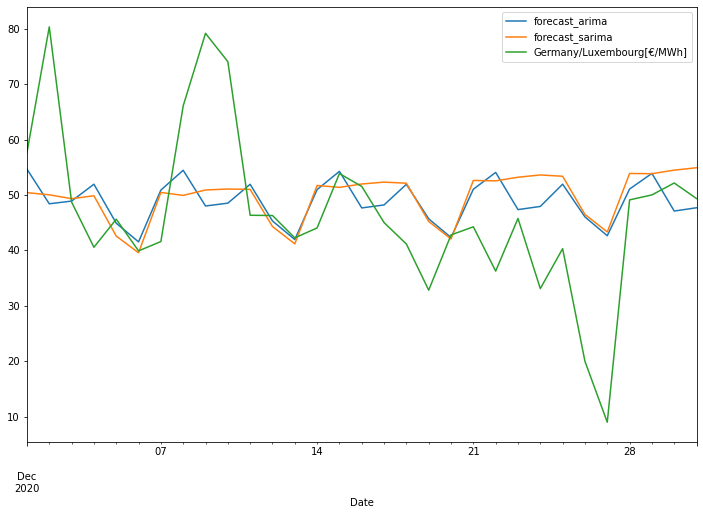

In [28]:
df_test[['forecast_arima','forecast_sarima', 'Germany/Luxembourg[€/MWh]']].plot(figsize=(12, 8))

In [29]:
df_test['Germany/Luxembourg[€/MWh]'].dropna(inplace=True)
df_test['residual_arima'] = df_test['Germany/Luxembourg[€/MWh]']- df_test['forecast_arima']
df_test['residual_sarima'] = df_test['Germany/Luxembourg[€/MWh]']- df_test['forecast_sarima']
df_test['residual_sarima'].dropna(inplace=True)
df_test['residual_arima'].dropna(inplace=True)

#Start the (G)arch Model
#Now we can fit the arch model using the best fit arima model parameters
p_ = order_arima[0]
o_ = order_arima[1]
q_ = order_arima[2]

# Using student T distribution usually provides better fit
garch_arima = arch_model(df_test['residual_arima'], p=p_, o=o_, q=q_  , dist='StudentsT')
res_garch_arima = garch_arima.fit(update_freq=5, disp='off')
print(res_garch_arima.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:               residual_arima   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -122.408
Distribution:      Standardized Student's t   AIC:                           270.815
Method:                  Maximum Likelihood   BIC:                           289.457
                                              No. Observations:                   31
Date:                      Thu, Jan 14 2021   Df Residuals:                       18
Time:                              19:40:05   Df Model:                           13
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -2

In [30]:
#Get Mean Arima
predicted_mu_arima = df_test['forecast_arima']
garch_arima_forecast = res_garch_arima.forecast(horizon=31, start='2020-12-01', method='simulation')

predicted_et_arima = garch_arima_forecast.mean['h.01'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction_garch_arima = predicted_mu_arima + predicted_et_arima
df_test['prediction_garch_arima'] = prediction_garch_arima


In [38]:
#Now we can fit the arch model using the best fit sarima model parameters
p_ = order_sarima[0]
o_ = order_sarima[1]
q_ = order_sarima[2]

# Using student T distribution usually provides better fit
garch_sarima = arch_model(df_test['residual_sarima'], p=p_, o=o_, q=q_  , dist='StudentsT')
res_garch_sarima = garch_sarima.fit(update_freq=5, disp='off')

garch_sarima_forecast = res_garch_sarima.forecast(horizon=31, start='2020-12-01', method='simulation')

predicted_mu_sarima = df_test['forecast_sarima']
predicted_et_sarima = garch_sarima_forecast.mean['h.01'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction_garch_sarima = predicted_mu_sarima + predicted_et_sarima
df_test['prediction_garch_sarima'] = prediction_garch_arima


print(res_garch_sarima.summary())


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:              residual_sarima   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:               -120.946
Distribution:      Standardized Student's t   AIC:                           253.892
Method:                  Maximum Likelihood   BIC:                           262.496
                                              No. Observations:                   31
Date:                      Thu, Jan 14 2021   Df Residuals:                       25
Time:                              19:46:42   Df Model:                            6
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -3

<AxesSubplot:xlabel='Date'>

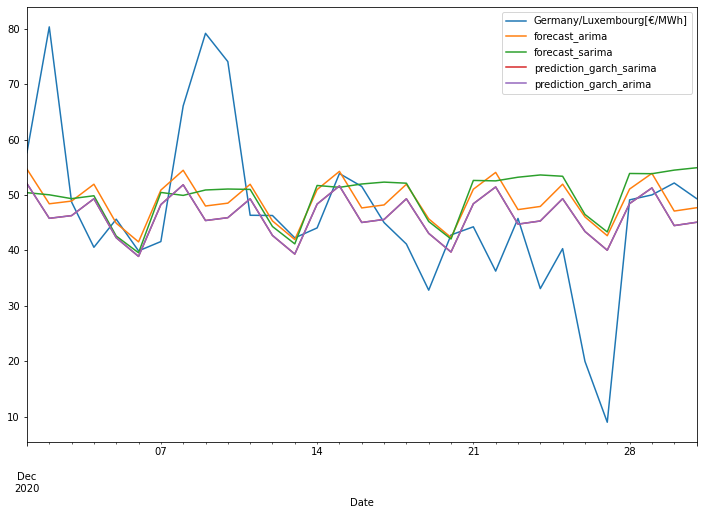

In [41]:
df_test[['Germany/Luxembourg[€/MWh]','forecast_arima','forecast_sarima', 'prediction_garch_sarima','prediction_garch_arima']].plot(figsize=(12, 8))

In [42]:
MSE_garch_arima=np.sum((df_test['prediction_garch_arima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_garch_arima=np.sum(np.abs((df_test['prediction_garch_arima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_garch_arima= np.sum((np.abs((df_test['prediction_garch_arima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_garch_sarima=np.sum((df_test['prediction_garch_sarima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_garch_sarima=np.sum(np.abs((df_test['prediction_garch_sarima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_garch_sarima= np.sum((np.abs((df_test['prediction_garch_sarima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_arima=np.sum((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_arima=np.sum(np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_arima= np.sum((np.abs((df_test['forecast_arima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100

MSE_sarima=np.sum((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])**2)/df_test.shape[0]
MAE_sarima=np.sum(np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]'])))/df_test.shape[0]
MAPE_sarima= np.sum((np.abs((df_test['forecast_sarima']-df_test['Germany/Luxembourg[€/MWh]']))/df_test['Germany/Luxembourg[€/MWh]'])/df_test.shape[0])*100


print('ARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_arima,MAE_arima,MAPE_arima))
print('SARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_sarima,MAE_sarima,MAPE_sarima))
print('GARCH ARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_garch_arima,MAE_garch_arima,MAPE_garch_arima))
print('GARCH SARIMA MODEL: \n  MSE: {} \n  MAE: {} \n  MAPE: {} \n'.format(MSE_garch_sarima,MAE_garch_sarima,MAPE_garch_sarima))

ARIMA MODEL: 
  MSE: 192.7976152776932 
  MAE: 9.573606046758696 
  MAPE: 31.520810016504452 

SARIMA MODEL: 
  MSE: 196.599387040295 
  MAE: 10.319184498059359 
  MAPE: 33.532771670860484 

GARCH ARIMA MODEL: 
  MSE: 188.82187021666334 
  MAE: 9.457575038544197 
  MAPE: 29.60968592214341 

GARCH SARIMA MODEL: 
  MSE: 188.82187021666334 
  MAE: 9.457575038544197 
  MAPE: 29.60968592214341 



QuantileTransformer()
QuantileTransformer()
QuantileTransformer()
QuantileTransformer()


<ipython-input-43-f3e4dc4ca945>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NN['Germany/Luxembourg[€/MWh]T-1'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(1)
<ipython-input-43-f3e4dc4ca945>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NN['Germany/Luxembourg[€/MWh]T-7'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(7)
<ipython-input-43-f3e4dc4ca945>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                350       
_________________________________________________________________
dense_1 (Dense)              (None, 480)               24480     
_________________________________________________________________
dropout (Dropout)            (None, 480)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6253      
_________________________________________________________________
dense_3 (Dense)              (None, 432)               6048      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                5629      
_________________________________________________________________
dense_5 (Dense)              (None, 384)               5

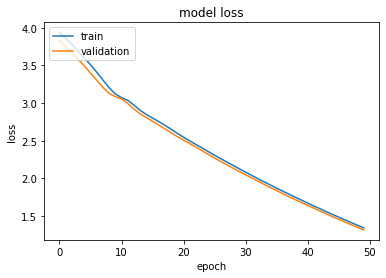

RUN PREDICTIONS ON VALIDATION DS
y-val mean: 34.644431818181815
predictions mean: 35.094967
mean squared error: 74.06706677707189
PLOT REAL VS PREDICTED FOR EACH SAMPLE


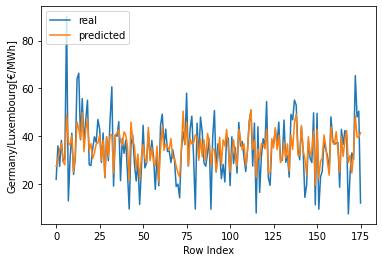

<Figure size 1440x576 with 0 Axes>

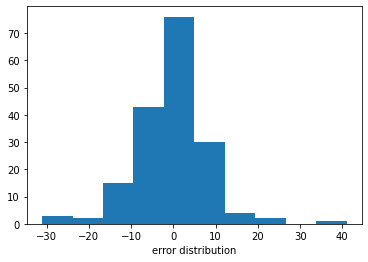

<Figure size 1440x576 with 0 Axes>

In [43]:
#Initialization NN

#SARIMAX-GARCH/ARMAX-GARCH model price prediction on day T;  
#historical price on day T-1; 
#historical price on day T-7; 
#historical price on day T-14; 
#non-base electricity demand on day T;  
#non-base electricity demand on day T-1.  

df_NN = df[['Germany/Luxembourg[€/MWh]','Non-base Demand[GWh]']]
df_NN['Germany/Luxembourg[€/MWh]T-1'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(1) 
df_NN['Germany/Luxembourg[€/MWh]T-7'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(7)
df_NN['Germany/Luxembourg[€/MWh]T-14'] =  df_NN['Germany/Luxembourg[€/MWh]'].shift(14)
df_NN['Non-base Demand[GWh]T-1'] =  df_NN['Non-base Demand[GWh]'].shift(1) 
  
# Combine both models' output: yt = mu + et
df_NN['Garch-Sarima Prediction'] = results_sarima.fittedvalues


df_NN.dropna(inplace=True, axis=0)
df_NN = df_NN[['Garch-Sarima Prediction','Germany/Luxembourg[€/MWh]','Non-base Demand[GWh]T-1', 'Germany/Luxembourg[€/MWh]T-14','Germany/Luxembourg[€/MWh]T-7','Germany/Luxembourg[€/MWh]T-1','Non-base Demand[GWh]']]

feature = 'Germany/Luxembourg[€/MWh]'
dim = len(df_NN.columns) - 1


#SPLIT TRAINING AND VALIDATION SET
X_train, X_val, y_train, y_val = train_test_split(df_NN, df_NN.pop(feature))
#SCALE X AND Y FOR TRAINING AND VALIDATION DS
scaler_x = QuantileTransformer()
scaler_y = QuantileTransformer()

y_train=y_train.values.reshape(-1,1)
y_val=y_val.values.reshape(-1,1)

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)

print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)

print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)

print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)
    
#CONFIGURE HYPERPARAMETER
size = 48 
    
    #DEFINE NN ARCHITECTURE
model = keras.Sequential([
    keras.layers.Dense(50, activation='relu',input_shape=(dim,)),
    keras.layers.Dense(size*10, activation='relu'),
    keras.layers.Dropout(.1), #here
    keras.layers.Dense(13, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    keras.layers.Dense(size*9, activation='relu'),
    keras.layers.Dense(13, kernel_regularizer='l2'),#hyperparameter optimization
    keras.layers.Dense(size*8, activation='relu'),
    keras.layers.Dense(13, kernel_regularizer='l1'),
    keras.layers.Dense(size*7, activation='relu'),
    # NOT USE REGULARIZATION AT THE LAST LAYER
    keras.layers.Dense(1, activation='linear') 
    ])
    
#SHOW MODEL CHARACTERISTICS
model.summary()
    
opt = keras.optimizers.Adam(learning_rate=0.0005)
    
#COMPILE MODEL
model.compile(#optimizer='adam',
              #optimizer='sgd',
              optimizer=opt,
              loss=tf.keras.losses.MeanSquaredError(),
              #metrics=['accuracy']
              metrics=['mse','mae','mean_absolute_percentage_error'])
#RUN MODEL
history =  model.fit(xtrain_scale, ytrain_scale, epochs=50, validation_split=0.25, batch_size=300)
print(history.history.keys())
print('PLOT TRAINING/VALIDATION CURVE AGAINST LOSS') 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
    
print('RUN PREDICTIONS ON VALIDATION DS')
predictions = model.predict(xval_scale) 
predictions = scaler_y.inverse_transform(predictions)
    
print("y-val mean: " + str(np.mean(y_val)))
print("predictions mean: " + str(np.mean(predictions)))
print("mean squared error: " + str(mean_squared_error(y_val,predictions)))
    
print("PLOT REAL VS PREDICTED FOR EACH SAMPLE") 
    
plt.xlabel("Row Index")
plt.ylabel(feature)
plt.plot(y_val) 
plt.plot(predictions)
plt.legend(['real', 'predicted'], loc='upper left')
plt.figure(figsize=(20,8))
plt.show()
    
#features.remove(feature)
plt.xlabel("error distribution")
plt.hist(y_val - predictions) 
plt.figure(figsize=(20,8))
plt.show()


In [44]:
df_test_NN = df_test[['Germany/Luxembourg[€/MWh]', 'Non-base Demand[GWh]', 'prediction_garch_sarima']]
df_test_NN = df_test_NN.append(df[['Germany/Luxembourg[€/MWh]', 'Non-base Demand[GWh]']].tail(14))
df_test_NN = df_test_NN.sort_index()
df_test_NN['Germany/Luxembourg[€/MWh]T-1'] =  df_test_NN['Germany/Luxembourg[€/MWh]'].shift(1) 
df_test_NN['Germany/Luxembourg[€/MWh]T-7'] =  df_test_NN['Germany/Luxembourg[€/MWh]'].shift(7)
df_test_NN['Germany/Luxembourg[€/MWh]T-14'] =  df_test_NN['Germany/Luxembourg[€/MWh]'].shift(14)
df_test_NN['Non-base Demand[GWh]T-1'] =  df_test_NN['Non-base Demand[GWh]'].shift(1) 
df_test_NN = df_test_NN['2020-12'][['Non-base Demand[GWh]', 'prediction_garch_sarima','Germany/Luxembourg[€/MWh]T-1','Germany/Luxembourg[€/MWh]T-7','Germany/Luxembourg[€/MWh]T-14','Non-base Demand[GWh]T-1']]


In [45]:
df_test_NN

,Non-base Demand[GWh],prediction_garch_sarima,Germany/Luxembourg[€/MWh]T-1,Germany/Luxembourg[€/MWh]T-7,Germany/Luxembourg[€/MWh]T-14,Non-base Demand[GWh]T-1
Date,,,,,,
2020-12-01,1309.447,52.049307,55.060,42.805,41.070,1287.443
2020-12-02,1287.784,45.789816,57.650,50.735,39.950,1309.447
2020-12-03,1349.598,46.277506,80.345,57.755,33.330,1287.784
2020-12-04,1322.055,49.321240,48.730,67.675,46.360,1349.598
2020-12-05,1071.720,42.283926,40.560,47.760,28.520,1322.055
2020-12-06,976.541,38.911063,45.630,45.040,27.815,1071.720
2020-12-07,1275.115,48.263932,39.910,55.060,45.230,976.541
2020-12-08,1286.610,51.841121,41.595,57.650,42.805,1275.115
2020-12-09,1281.207,45.390550,66.085,80.345,50.735,1286.610


In [46]:
#scaler_x = QuantileTransformer()
print(scaler_x.fit(df_test_NN))
xtest_scale = scaler_x.transform(df_test_NN)
predictions = model.predict(xtest_scale)
predictions = scaler_y.inverse_transform(predictions)
df_test_NN = df_test_NN.reset_index()
df_test_NN['PredictionsNN'] = predictions 
df_test_NN = df_test_NN.set_index('Date')

/home/cronos/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (31). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


QuantileTransformer()


<AxesSubplot:xlabel='Date'>

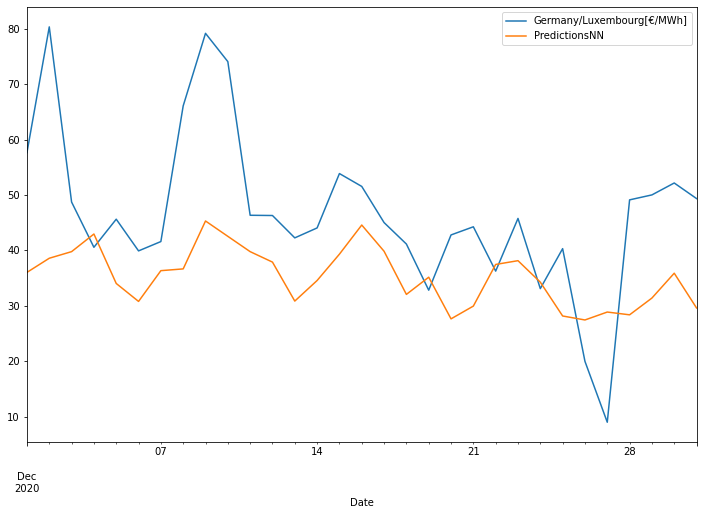

In [47]:
df_test['Germany/Luxembourg[€/MWh]'].plot(legend='Observed',figsize=(12, 8))
df_test_NN['PredictionsNN'].plot(legend='Estimated',figsize=(12, 8))